In [46]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

#### Solve the original system for full-field solution

In [47]:
wavelength = 1.0/20;
wavenumber = 2*pi/wavelength
C = Expression("1.5 + sin(k*x[0])", k=wavenumber, degree=2)

# create a very fine mesh so that it the finite element solution can capture
# the fluctuation in the material parameter C
mesh = UnitIntervalMesh(500)
V = FunctionSpace(mesh, "Lagrange", 1)

u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(v), C * grad(u)) * dx 
L = Expression("x[0]", degree=2) * v * dx
# solve PDE for the full-field solution
u_ff = Function(V)
solve(a == L, u_ff, DirichletBC(V, Constant(0.0), (
    lambda x, on_boundary: near(x[0], 0, DOLFIN_EPS_LARGE) and on_boundary)))

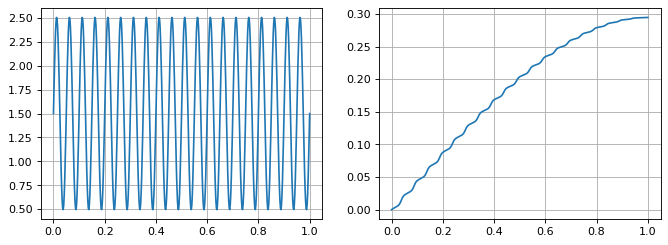

In [48]:
# plot material parameter and solution
plt.figure(figsize=(10,3.5), dpi=80)
plt.subplot(1,2,1)
plot(project(C, V)); plt.grid()
plt.subplot(1,2,2)
plot(u_ff); plt.grid()

#### Solve the microscopic BVP to obtain the macroscopic elastic tensor

Solve microscopic boundary value problem
\begin{equation}
    \frac{d}{d x}(C(x) (\tilde{u}^{\prime} + \overline{\epsilon}) = 0, \quad x \in \Omega_{\mathrm{RVE}}
\end{equation}
with the periodic boundary condition on $\tilde{u}$. To eliminate the rigid-body motion, we add one artificial condition
\begin{equation}
    \int_{\Omega_{\mathrm{RVE}}} u dx = 0
\end{equation}

In [13]:
wavelength = 1.0/20
wavenumber = 2*np.pi/wavelength
vertices = np.array([-wavelength/2, wavelength/2])
mesh_RVE = IntervalMesh(200, vertices[0], vertices[1])

# volume of the RVE
vol = vertices[1] - vertices[0]

kappa = Expression("1.5 + sin(k*x[0])", k=wavenumber, degree=2)

class PeriodicBoundary(SubDomain):
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.vertices = vertices
        self.TOL = TOL
        
    def inside(self, x, on_boundary):
        return near(x[0], self.vertices[0], self.TOL) and on_boundary
    
    # map the point x to y:: The solution at y should be equal to the solution at x
    # x belongs to the boundary parts defined by method "inside" (see above)
    def map(self, x, y):
        y[0] = x[0] - (self.vertices[1] - self.vertices[0])

In [15]:
def epsilon(u):
    return u.dx(0)

def sigma(u, eps_):
    return kappa * (u.dx(0) + eps_)

def boundary(x, on_boundary):
    return near(x[0], vertices[0], 1E-10) and on_boundary

In [32]:
ElemU = FiniteElement("CG", mesh_RVE.ufl_cell(), 1)
ElemL = FiniteElement("R", mesh_RVE.ufl_cell(), 0) # this produces only one scalar (function with only one 1 DOF, its value)
# W = FunctionSpace(mesh_RVE, MixedElement([ElemU, ElemL]), 
#                 constrained_domain=PeriodicBoundary(vertices))

bcs = DirichletBC(mesh_RVE, MixedElement)
W = FunctionSpace(mesh_RVE, MixedElement([ElemU, ElemL]), bcs)

In [33]:
u, lambda_ = TrialFunction(W)   # u is the fluctuation, c is the Lagrange multiplier
v, virtual_lambda_ = TestFunction(W)    # test function dual to u and c

MacroStrain = Constant(1.0)
F = dot(epsilon(v), sigma(u, MacroStrain ))*dx + lambda_*v*dx + u*virtual_lambda_ *dx 
a, L = lhs(F), rhs(F)
w = Function(W)

solve(a == L, w, [])

u_fluc, lagrange_mul = w.split()

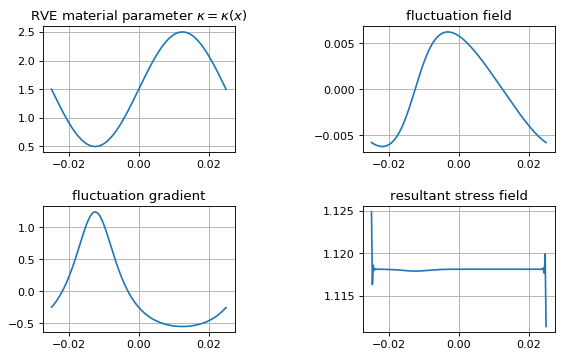

In [43]:
plt.figure(figsize=(8,4.5), dpi=80)
plt.subplot(position=[0.1, 0.9, 0.3, 0.35])
plot(project(kappa, FunctionSpace(mesh_RVE, 'CG', 1)), title="RVE material parameter $\kappa = \kappa(x)$"); plt.grid();

plt.subplot(position=[0.6, 0.9, 0.3, 0.35])
plot(u_fluc, title="fluctuation field"); plt.grid()

plt.subplot(position=[0.1, 0.4, 0.3, 0.35])
plot(u_fluc.dx(0), title="fluctuation gradient"); plt.grid()

plt.subplot(position=[0.6, 0.4, 0.3, 0.35])
plot(sigma(u_fluc, MacroStrain), title="resultant stress field"); plt.grid()

In [49]:
C_Macro = assemble(sigma(u_fluc, Constant(1.0))*dx) / wavelength
print(C_Macro)
print("C_Macro_num - C_Macro_anal =", C_Macro - np.sqrt(5)/2)

1.1180707684762934
C_Macro_num - C_Macro_anal = 3.67797263984837e-05


#### Solve the homogenized boundary value problem

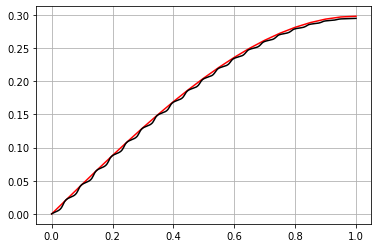

In [50]:
mesh_Macro = UnitIntervalMesh(20)
V_Macro = FunctionSpace(mesh_Macro, "CG", 2)

def boundary(x, on_boundary):
    return near(x[0], 0, 1E-10) and on_boundary

f = Expression("x[0]", degree=2)

u = TrialFunction(V_Macro)
v = TestFunction(V_Macro)
a = dot(grad(v), Constant(C_Macro) * grad(u)) * dx 
L = f * v * dx
# solve PDE
u_homo = Function(V_Macro)
solve(a == L, u_homo, DirichletBC(V_Macro, Constant(0.0), lambda x, on_boundary: near(x[0], 0) and on_boundary))

plot(u_homo, color='red', linestyle="-"); plt.grid()
plot(u_ff, color="black")